# Electricity Production Forecasting ⚡


# ARIMA and Seasonal ARIMA
##### Autoregressive Integrated Moving Averages

#### Content:
1. Loading Packages
2. Loading Data
    * Importing the Excel file
    * Summary of the basic information of the DF
    * Data Visualization
3. Test of Stationarity
    * Mean of Data
    * Variance of Data
    * Augmented Dickey-Fuller Test (adfuller)
4. Turning into Stationarity
    * Differencing
    * Removing Trend
    * Removing Seasonality
5. Auto Regressive Model
    * ACF & PACF for Trend
    * ACF & PACF for Seasonality
6. Forecasting Models
    * ARIMA Model
    * SARIMA Model
    * Conclusion of the models
7. Obtaining MSE and MAE
    * Errors
8. Forecasting three years from last value
9. Conclusions
    * Comparing errors

***
### Loading Packages
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sys
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import quarter_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from matplotlib import colors
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from scipy import signal

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

***
### Loading Data
***

* Importing the Excel file

In [2]:
df = pd.read_csv(r'Electric_Production.csv', parse_dates = ['DATE'])

df.head(3)

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502


In [3]:
df.rename(columns={'DATE': 'date','IPG2211A2N': 'value'}, inplace=True) #we replace columns names with a dictionary
df['date']=pd.to_datetime(df['date']) #we format the column to pandas date type
df.set_index('date',inplace=True) #we set the date type column as index to be able to apply time series methods.

df.head(3)

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502


* Summary of the basic information of the DF

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,397.0,88.847218,15.387834,55.3151,77.1052,89.7795,100.5244,129.4048


In [5]:
df['value'].isnull().sum() #we check for empty values in case we may need to address that issue.

0

In [6]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


* Data Visualization

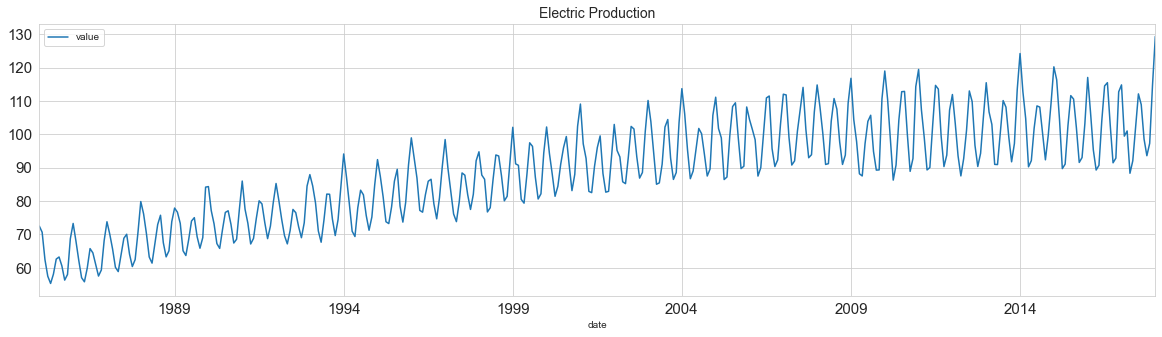

In [7]:
df.plot(figsize=(20, 5))
plt.title("Electric Production", size = 14)
plt.legend(loc = 'upper left')

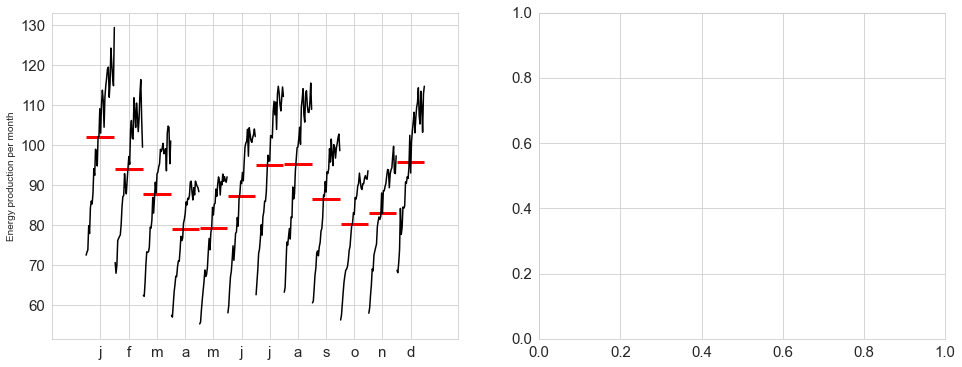

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
month_plot(df['value'],ylabel='Energy production per month', ax=ax[0]);

***
### Test of Stationarity
***

* Mean of Data

In [9]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


* Variance of Data

In [10]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


* Augmented Dickey-Fuller Test (adfuller)

In [11]:
test_result=adfuller(df['value'])
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['value'])   

ADF Test Statistic : -2.2569903500472455
p-value : 0.18621469116586759
#Lags Used : 15
Number of Observations Used : 381
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


***
### Turning into Stationarity
***

* Differencing

In [12]:
#Because our data is not stationary, we proceed to apply differencing to remove the trend.
df['value First Difference'] = df['value'] - df['value'].shift(1)
#We also apply differencing to remove the seasonality
df['Seasonal First Difference']=df['value']-df['value'].shift(12)

In [13]:
#we check the results obtained, value first difference and seasonal differencing.
df.head(14)

,value,value First Difference,Seasonal First Difference
date,,,
1985-01-01,72.5052,NaN,NaN
1985-02-01,70.6720,-1.8332,NaN
1985-03-01,62.4502,-8.2218,NaN
1985-04-01,57.4714,-4.9788,NaN
1985-05-01,55.3151,-2.1563,NaN
1985-06-01,58.0904,2.7753,NaN
1985-07-01,62.6202,4.5298,NaN
1985-08-01,63.2485,0.6283,NaN
1985-09-01,60.5846,-2.6639,NaN


* Removing Trend

ADF Test Statistic : -7.104890882267354
p-value : 4.077786565538474e-10
#Lags Used : 14
Number of Observations Used : 381
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

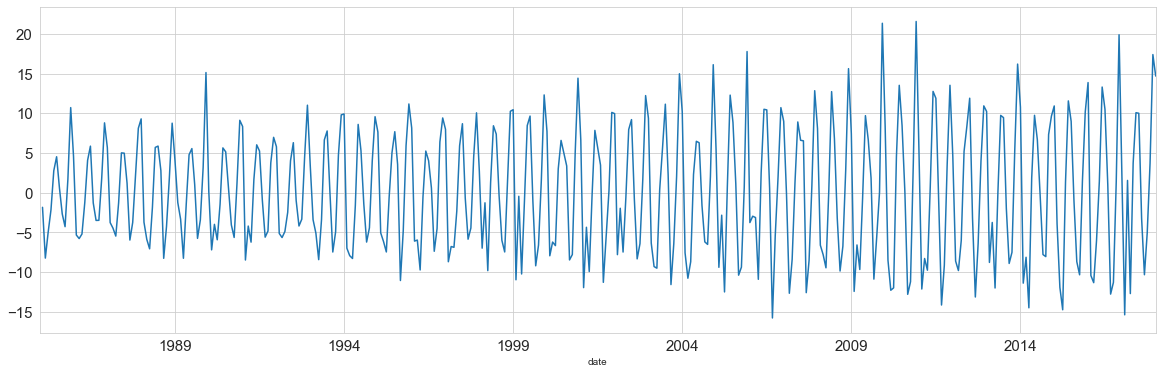

In [14]:
## We apply adfuller test to trend results, taking into account to drop the NA values.
adfuller_test(df['value First Difference'].dropna())
df['value First Difference'].plot(figsize=(20, 6))

* Removing Seasonality

ADF Test Statistic : -5.673482023381764
p-value : 8.812644938088811e-07
#Lags Used : 12
Number of Observations Used : 372
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

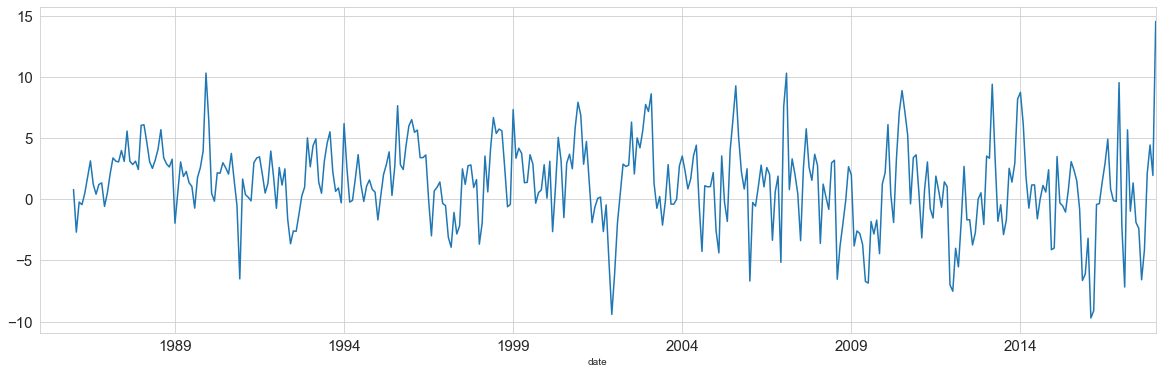

In [15]:
## We apply adfuller test to seasonal results, taking into account to drop the NA values.
adfuller_test(df['Seasonal First Difference'].dropna())
df['Seasonal First Difference'].plot(figsize=(20, 6))

***
### Auto Regressive Model
***

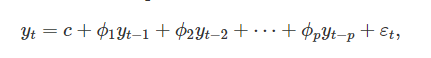

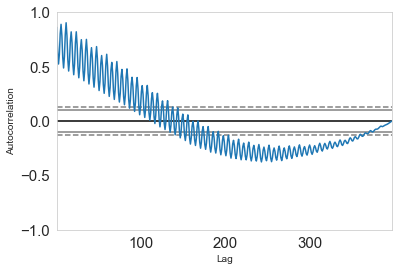

In [16]:
#we apply autocorrelation plot to initial data (includes trend and seasonality)
autocorrelation_plot(df['value'])
plt.show()

* ACF & PACF for **Trend**

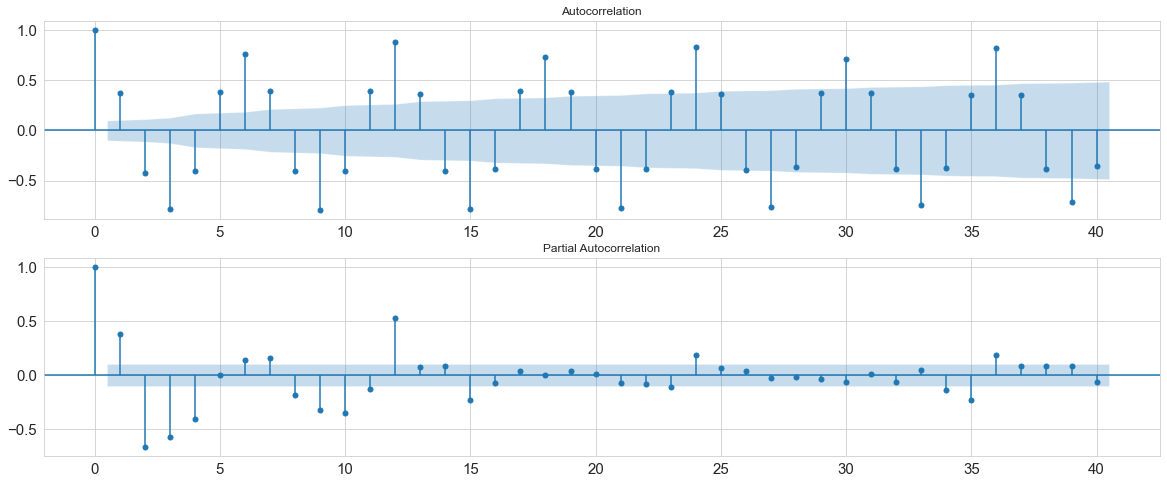

In [17]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['value First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['value First Difference'].iloc[1:],lags=40,ax=ax2)

* ACF & PACF for **Seasonality**

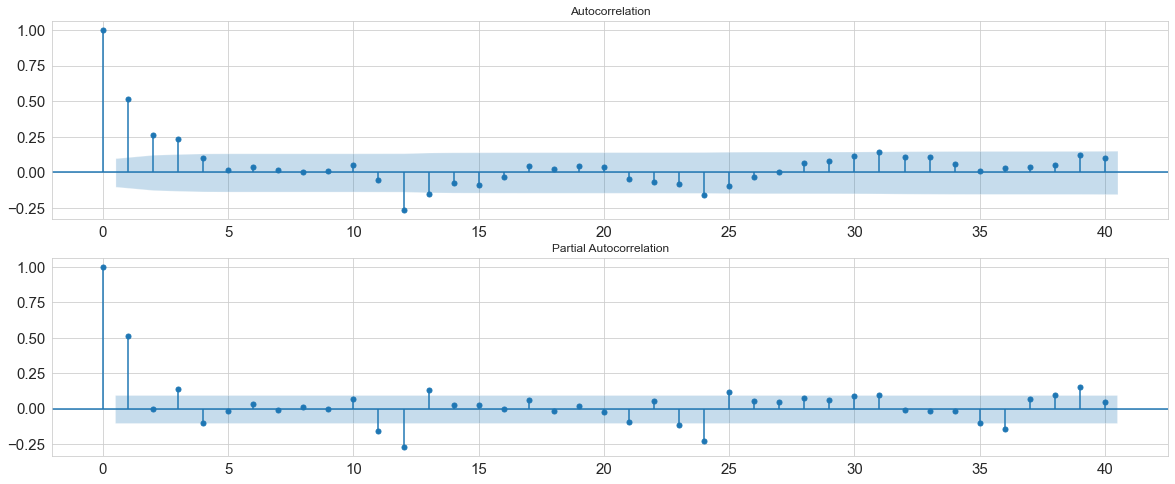

In [18]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

***
### Forecasting Models
***

* **ARIMA** Model

In [19]:
model = ARIMA(endog=df['value'],order=(3,1,3),freq='MS') #p,d,q
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  397
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1045.684
Date:                Mon, 06 Dec 2021   AIC                           2105.369
Time:                        00:11:43   BIC                           2133.239
Sample:                    01-01-1985   HQIC                          2116.410
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0377      0.082      0.459      0.646      -0.123       0.199
ar.L2         -0.0372      0.082     -0.453      0.651      -0.198       0.124
ar.L3         -0.9620      0.082    -11.714      0.000      -1.123      -0.801
ma.L1         -0.0935      0.096     -0.973      0.331      -0.282       0.095
ma.L2         -0.0112      0.102     -0.110      0.913      -0.212       0.189
ma.L3          0.9309      0.098      9.533      0.000       0.739       1.122
sigma2        11.2175      0.654     17.165      0.000       9.937      12.498
===================================================================================
Ljung-Box (L1) (Q):                   6.24   Jarque-Bera (JB):                25.03
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

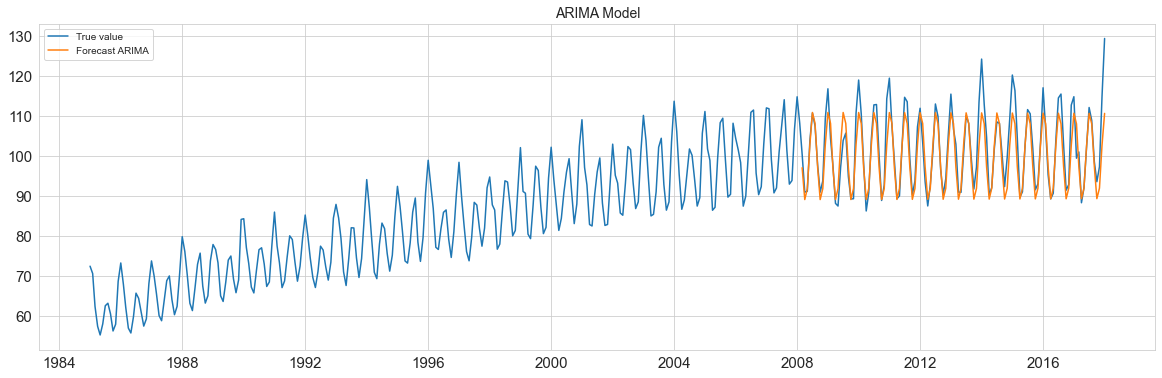

In [20]:
plt.figure(figsize = (20,6))
df['ARIMA_forecast'] = model_fit.predict(start=278,end=397,dynamic=True)
plt.plot(df['value'], label = 'True value', linestyle="-")
plt.plot(df['ARIMA_forecast'], label = 'Forecast ARIMA', linestyle="-")
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.legend()

* **SARIMA** Model

In [21]:
model = sm.tsa.statespace.SARIMAX(df['value'],order=(3, 1, 3),seasonal_order=(3,1,3,12),freq='MS')
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  397
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -875.109
Date:                            Mon, 06 Dec 2021   AIC                           1776.219
Time:                                    00:11:55   BIC                           1827.577
Sample:                                01-01-1985   HQIC                          1796.590
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0106      0.134     -0.078      0.937      -0.274       0.253
ar.L2         -0.5926      0.122     -4.859      0.000      -0.832      -0.354
ar.L3          0.4764      0.069      6.934      0.000       0.342       0.611
ma.L1         -0.4287      0.129     -3.331      0.001      -0.681      -0.177
ma.L2          0.3150      0.155      2.030      0.042       0.011       0.619
ma.L3         -0.7804      0.125     -6.240      0.000      -1.026      -0.535
ar.S.L12      -0.2152      3.517     -0.061      0.951      -7.108       6.677
ar.S.L24       0.0960      1.884      0.051      0.959      -3.597       3.789
ar.S.L36      -0.2551      1.214     -0.210      0.834      -2.634       2.124
ma.S.L12      -0.4834      3.507     -0.138      0.890      -7.357       6.390
ma.S.L24      -0.4717      4.311     -0.109      0.913      -8.921       7.978
ma.S.L36       0.3928      1.707      0.230      0.818      -2.953       3.738
sigma2         5.3633      0.319     16.823      0.000       4.738       5.988
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                23.12
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
df.tail(5)

,value,value First Difference,Seasonal First Difference,ARIMA_forecast
date,,,,
2017-09-01,98.6154,-10.3158,-4.1483,97.411045
2017-10-01,93.6137,-5.0017,2.1270,89.377921
2017-11-01,97.3359,3.7222,4.4459,91.996005
2017-12-01,114.7212,17.3853,1.9518,102.649896
2018-01-01,129.4048,14.6836,14.5543,110.681213


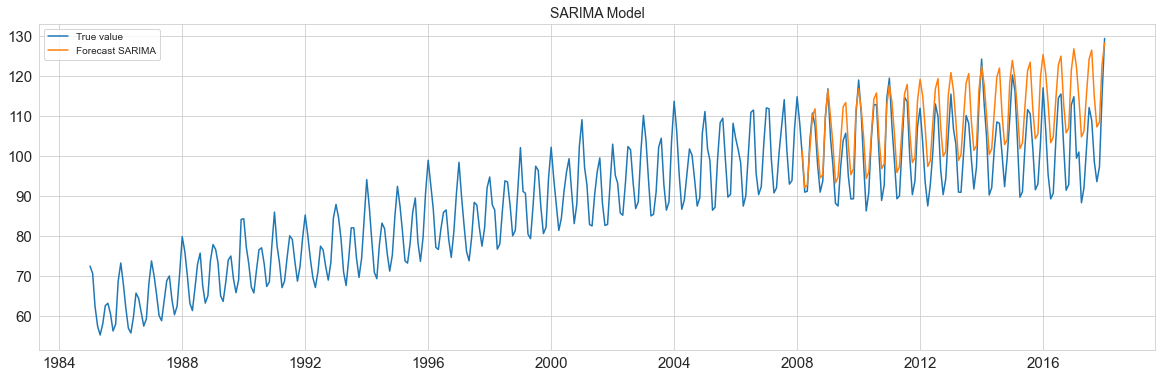

In [23]:
plt.figure(figsize = (20,6))
df['SARIMA_forecast']=model_fit.predict(start=278,end=397,dynamic=True)
plt.plot(df['value'], label = 'True value', linestyle="-")
plt.plot(df['SARIMA_forecast'], label = 'Forecast SARIMA', linestyle="-")
plt.title("SARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.legend()

* Conclusion of the forecasting model

    Looking at the AIC value at the resumes of both models, we get a better fit using SARIMA model, it makes sense because our model does have seasonality.

***
### Obtaining MSE and MAE
***

* Errors

We proceed to select equal sized of data to compare them in mean square error and absolut error functions.

In [24]:
df_original = df
df_original = df_original.reset_index() #we reset index to be able to select rows by integers
df_original = df_original.rename(columns={"index":"date"})
df_original = df_original[['date','value']]
df_original = df_original.loc[ 278:396 , ['date','value'] ] # here we cut only the piece we want
df_original.set_index('date',inplace=True) #here we go back to indexing by date, we need this for the error functions.
type(df_original)

pandas.core.frame.DataFrame

In [25]:
df_prediction = df
df_prediction = df_prediction.reset_index()
df_prediction = df_prediction.rename(columns={"index":"date"})
df_prediction = df_prediction[['date','SARIMA_forecast']]
df_prediction = df_prediction.loc[278:396,['date','SARIMA_forecast']]
df_prediction.set_index('date',inplace=True)
type(df_prediction)

pandas.core.frame.DataFrame

[]

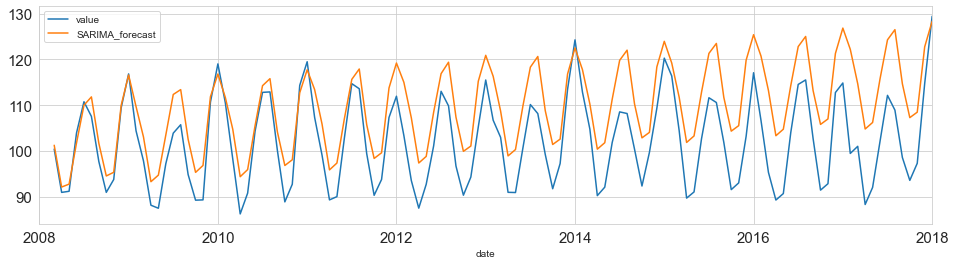

In [26]:
df_graph = df_original
df_graph['SARIMA_forecast']=df_prediction['SARIMA_forecast']
ax = df_graph.plot(figsize=(16,4))
dates = pd.date_range('2008', '2018', freq=pd.DateOffset(years=2))
ax.xaxis.set_ticks(dates)
ax.xaxis.set_ticklabels(dates.strftime('%Y'))
ax.plot()

In [27]:
#we convert the dataframes to series
ytrue = df_original['value']
ypred = df_prediction['SARIMA_forecast']

from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(ytrue,ypred)}')
print(f'Mean Squared Error = {mean_squared_error(ytrue,ypred)}')

Mean Absolute Error = 7.905600509223593
Mean Squared Error = 82.6904084637785


***
### Forecasting three years from last value
***

[]

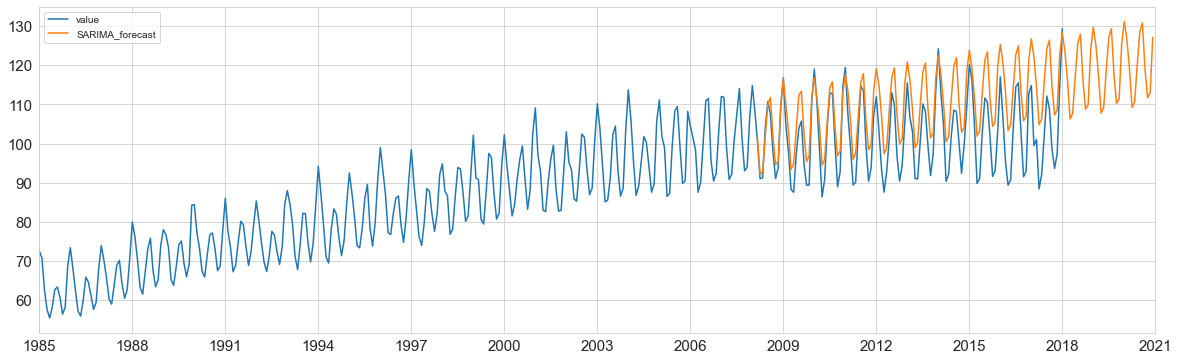

In [28]:
#we create a list with time stamps for the next two years
future_dates = [df.index[-1]+ DateOffset(months=x) for x in range(0,36)] 

#we create a dataframe that uses the future_dates list of timestamps as index, also copy the columns names of df.
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

#now we concatenate df and future_dates_df into future_df dataframe
future_df =pd.concat([df,future_dates_df])
future_df['SARIMA_forecast'] = model_fit.predict(start=278,end=697,dynamic=True)
ax = future_df[['value','SARIMA_forecast']].plot(figsize=(20, 6))

dates = pd.date_range('1985', '2021', freq=pd.DateOffset(years=3))
ax.xaxis.set_ticks(dates)
ax.xaxis.set_ticklabels(dates.strftime('%Y'))
ax.plot()

***
### Conclusions
***

* Comparing errors

In [29]:
errors = pd.DataFrame()
errors["Model"] = ["SARIMA", "Triple Exponential Smoothing"]
errors["Mean Absolute Error (MAE)"] = [mean_absolute_error(df_original['value'],df_prediction['SARIMA_forecast']), 8.628]
errors["Mean Squared Error (MSE)"] = [mean_squared_error(df_original['value'],df_prediction['SARIMA_forecast']), 103.970]
errors.index = errors.Model
del errors["Model"]
errors

,Mean Absolute Error (MAE),Mean Squared Error (MSE)
Model,,
SARIMA,7.905601,82.690408
Triple Exponential Smoothing,8.628000,103.970000
